In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 8000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)
    
    # Convolution Layer
    conv6 = conv2d(conv5, weights['wc6'], biases['bc6'])
    conv7 = conv2d(conv6, weights['wc7'], biases['bc7'])
    # Max Pooling (down-sampling)
    conv7 = maxpool2d(conv7, k=2)
    print(conv6.shape)
    print(conv7.shape)
  
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv7, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
   
    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 2x3 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([2, 3, 1, 32])),
    # 2x3 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([2, 3, 32, 64])),
    # 2x3 conv, 32 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([2, 3, 64, 64])),
    # 2x3 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([2, 3, 64, 32])),
    # 2x3 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([2, 3, 32, 64])),
    # 2x3 onv, 64 inputs, 32 outputs
    'wc6': tf.Variable(tf.random_normal([2, 3, 64, 32])),
    # 2x3 conv, 64 inputs, 32 outputs
    'wc7': tf.Variable(tf.random_normal([2, 3, 32, 32])),
    # fully connected, 2*2*32 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([1*1*32, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bc6': tf.Variable(tf.random_normal([32])),
    'bc7': tf.Variable(tf.random_normal([32])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 32)
(?, 2, 2, 64)
(?, 2, 2, 32)
(?, 1, 1, 32)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 127777872.000000, Accuracy = 0.107999995351
Performance on test set: Training epochs #1000, Batch Loss = 71551712.0, Accuracy = 0.185000002384
Training epochs #20000: Batch Loss = 93464776.000000, Accuracy = 0.0870000049472
Performance on test set: Training epochs #20000, Batch Loss = 100595560.0, Accuracy = 0.0
Training epochs #40000: Batch Loss = 79164192.000000, Accuracy = 0.00499999988824
Performance on test set: Training epochs #40000, Batch Loss = 63379704.0, Accuracy = 0.0
Training epochs #60000: Batch Loss = 47548176.000000, Accuracy = 0.0640000030398
Performance on test set: Training epochs #60000, Batch Loss = 29996922.0, Accuracy = 0.0
Training epochs #80000: Batch Loss = 27703988.000000, Accuracy = 0.221000000834
Performance on test set: Training epochs #80000, Batch Loss = 7998122.5, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 66644172.000000, Accuracy = 0.0799999982119
Performance on test set: Training epochs #100000

Training epochs #920000: Batch Loss = 2001325.750000, Accuracy = 0.716000020504
Performance on test set: Training epochs #920000, Batch Loss = 425939.59375, Accuracy = 0.942999958992
Training epochs #940000: Batch Loss = 1747853.500000, Accuracy = 0.801000058651
Performance on test set: Training epochs #940000, Batch Loss = 564994.5, Accuracy = 0.943000078201
Training epochs #960000: Batch Loss = 1326359.250000, Accuracy = 0.86000007391
Performance on test set: Training epochs #960000, Batch Loss = 634428.6875, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 10559598.000000, Accuracy = 0.226999998093
Performance on test set: Training epochs #980000, Batch Loss = 301536.3125, Accuracy = 0.949000000954
Training epochs #1000000: Batch Loss = 1596887.125000, Accuracy = 0.763000011444
Performance on test set: Training epochs #1000000, Batch Loss = 363778.3125, Accuracy = 0.943000078201
Training epochs #1020000: Batch Loss = 1254043.500000, Accuracy = 0.827000021935
Performan

Training epochs #1820000: Batch Loss = 520328.812500, Accuracy = 0.884000062943
Performance on test set: Training epochs #1820000, Batch Loss = 189648.90625, Accuracy = 0.961000084877
Training epochs #1840000: Batch Loss = 343826.656250, Accuracy = 0.919000029564
Performance on test set: Training epochs #1840000, Batch Loss = 182487.578125, Accuracy = 0.961000025272
Training epochs #1860000: Batch Loss = 3809123.500000, Accuracy = 0.413999974728
Performance on test set: Training epochs #1860000, Batch Loss = 83092.71875, Accuracy = 0.981999993324
Training epochs #1880000: Batch Loss = 496745.031250, Accuracy = 0.884000062943
Performance on test set: Training epochs #1880000, Batch Loss = 162977.65625, Accuracy = 0.967999994755
Training epochs #1900000: Batch Loss = 468608.625000, Accuracy = 0.878000020981
Performance on test set: Training epochs #1900000, Batch Loss = 176716.65625, Accuracy = 0.961000025272
Training epochs #1920000: Batch Loss = 276708.187500, Accuracy = 0.92300003767


Training epochs #2720000: Batch Loss = 214116.828125, Accuracy = 0.930999994278
Performance on test set: Training epochs #2720000, Batch Loss = 76342.296875, Accuracy = 0.967999994755
Training epochs #2740000: Batch Loss = 1743952.500000, Accuracy = 0.580000042915
Performance on test set: Training epochs #2740000, Batch Loss = 44392.078125, Accuracy = 0.991000056267
Training epochs #2760000: Batch Loss = 229341.468750, Accuracy = 0.933000028133
Performance on test set: Training epochs #2760000, Batch Loss = 98768.046875, Accuracy = 0.976000010967
Training epochs #2780000: Batch Loss = 229807.750000, Accuracy = 0.933000087738
Performance on test set: Training epochs #2780000, Batch Loss = 88836.640625, Accuracy = 0.967999994755
Training epochs #2800000: Batch Loss = 166651.968750, Accuracy = 0.945000112057
Performance on test set: Training epochs #2800000, Batch Loss = 73616.4140625, Accuracy = 0.967999994755
Training epochs #2820000: Batch Loss = 1730018.250000, Accuracy = 0.5570000410

Training epochs #3620000: Batch Loss = 985407.812500, Accuracy = 0.650000035763
Performance on test set: Training epochs #3620000, Batch Loss = 31627.8476562, Accuracy = 0.991000056267
Training epochs #3640000: Batch Loss = 116044.023438, Accuracy = 0.952000021935
Performance on test set: Training epochs #3640000, Batch Loss = 43184.0390625, Accuracy = 0.976000010967
Training epochs #3660000: Batch Loss = 87209.656250, Accuracy = 0.949999988079
Performance on test set: Training epochs #3660000, Batch Loss = 38000.4023438, Accuracy = 0.983000040054
Training epochs #3680000: Batch Loss = 78553.132812, Accuracy = 0.973000049591
Performance on test set: Training epochs #3680000, Batch Loss = 34973.4960938, Accuracy = 0.990000069141
Training epochs #3700000: Batch Loss = 967168.437500, Accuracy = 0.631999969482
Performance on test set: Training epochs #3700000, Batch Loss = 28555.2578125, Accuracy = 0.991000056267
Training epochs #3720000: Batch Loss = 130898.640625, Accuracy = 0.9560000300

Training epochs #4520000: Batch Loss = 88358.148438, Accuracy = 0.957000076771
Performance on test set: Training epochs #4520000, Batch Loss = 54748.359375, Accuracy = 0.975999951363
Training epochs #4540000: Batch Loss = 67259.671875, Accuracy = 0.969000101089
Performance on test set: Training epochs #4540000, Batch Loss = 23079.3945312, Accuracy = 0.990000128746
Training epochs #4560000: Batch Loss = 41691.542969, Accuracy = 0.976000010967
Performance on test set: Training epochs #4560000, Batch Loss = 19736.6816406, Accuracy = 0.990000128746
Training epochs #4580000: Batch Loss = 577014.562500, Accuracy = 0.701000034809
Performance on test set: Training epochs #4580000, Batch Loss = 20745.203125, Accuracy = 0.991000056267
Training epochs #4600000: Batch Loss = 97435.445312, Accuracy = 0.960000038147
Performance on test set: Training epochs #4600000, Batch Loss = 49633.3359375, Accuracy = 0.976000010967
Training epochs #4620000: Batch Loss = 56712.515625, Accuracy = 0.967000007629
Pe

Training epochs #5420000: Batch Loss = 32465.601562, Accuracy = 0.978999912739
Performance on test set: Training epochs #5420000, Batch Loss = 16833.1132812, Accuracy = 0.990000069141
Training epochs #5440000: Batch Loss = 14030.861328, Accuracy = 0.98400002718
Performance on test set: Training epochs #5440000, Batch Loss = 12764.4970703, Accuracy = 0.990000069141
Training epochs #5460000: Batch Loss = 348771.218750, Accuracy = 0.743999958038
Performance on test set: Training epochs #5460000, Batch Loss = 15769.7099609, Accuracy = 0.991000056267
Training epochs #5480000: Batch Loss = 53148.296875, Accuracy = 0.97000002861
Performance on test set: Training epochs #5480000, Batch Loss = 21372.6503906, Accuracy = 0.990000009537
Training epochs #5500000: Batch Loss = 39561.789062, Accuracy = 0.976000070572
Performance on test set: Training epochs #5500000, Batch Loss = 15539.5478516, Accuracy = 0.990000009537
Training epochs #5520000: Batch Loss = 14591.577148, Accuracy = 0.990000009537
Pe

Training epochs #6320000: Batch Loss = 15025.964844, Accuracy = 0.987999975681
Performance on test set: Training epochs #6320000, Batch Loss = 9721.57617188, Accuracy = 0.991000056267
Training epochs #6340000: Batch Loss = 276534.062500, Accuracy = 0.768000006676
Performance on test set: Training epochs #6340000, Batch Loss = 14571.1523438, Accuracy = 0.991000056267
Training epochs #6360000: Batch Loss = 51253.250000, Accuracy = 0.965000033379
Performance on test set: Training epochs #6360000, Batch Loss = 19333.3222656, Accuracy = 0.976000010967
Training epochs #6380000: Batch Loss = 23620.375000, Accuracy = 0.975999951363
Performance on test set: Training epochs #6380000, Batch Loss = 9530.98144531, Accuracy = 0.993000090122
Training epochs #6400000: Batch Loss = 7073.903320, Accuracy = 0.988999962807
Performance on test set: Training epochs #6400000, Batch Loss = 8094.88867188, Accuracy = 0.994000077248
Training epochs #6420000: Batch Loss = 279895.812500, Accuracy = 0.770000040531


Training epochs #7220000: Batch Loss = 153345.765625, Accuracy = 0.816999912262
Performance on test set: Training epochs #7220000, Batch Loss = 6679.24609375, Accuracy = 0.991000056267
Training epochs #7240000: Batch Loss = 12672.382812, Accuracy = 0.983000040054
Performance on test set: Training epochs #7240000, Batch Loss = 3082.02441406, Accuracy = 0.993000149727
Training epochs #7260000: Batch Loss = 13310.280273, Accuracy = 0.988000094891
Performance on test set: Training epochs #7260000, Batch Loss = 3217.99780273, Accuracy = 0.993000149727
Training epochs #7280000: Batch Loss = 6745.023926, Accuracy = 0.992000102997
Performance on test set: Training epochs #7280000, Batch Loss = 2541.71875, Accuracy = 0.994000077248
Training epochs #7300000: Batch Loss = 157597.125000, Accuracy = 0.808999955654
Performance on test set: Training epochs #7300000, Batch Loss = 11741.8232422, Accuracy = 0.991000056267
Training epochs #7320000: Batch Loss = 31437.884766, Accuracy = 0.969999969006
Per

# performance visualization

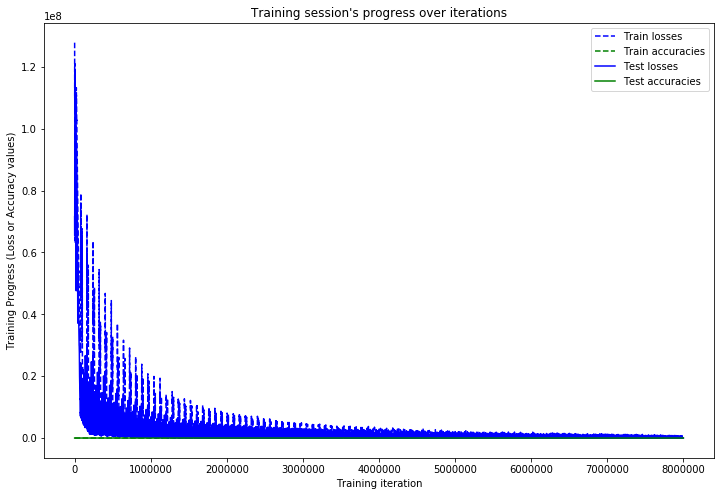

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 94.2224061547%
Recall: 94.37%
f1_score: 93.6364044247%

Confusion Matrix:
[[    0    12     0     0     0     6     0     0     0     0     0     0
      0]
 [    1   637     0     0    27    77   144    14     5     0     0     6
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0    99     0     0  2733    10    35    10     0     0     0     4
      0]
 [    3    35     0     0     2   286    16     6     0     0     0     0
      0]
 [    0     6     0     0     0     3 14486     0     0     0     0     0
      0]
 [    0    32     0     0    34   342    79    34    11     0     0     3
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     1     0     0     0     0     0     0     0     1     0     2
      0]
 [    0     0     0     0     0     0     0   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


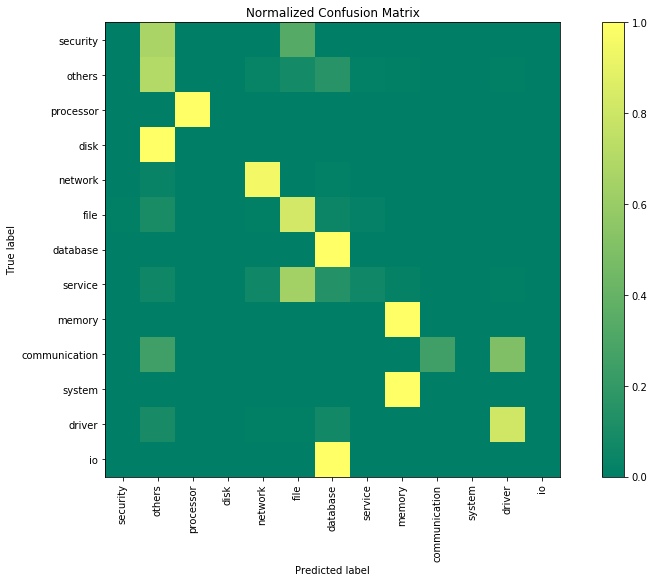

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)